CLoNe - Clustering based on local neighborhoods
---------------------------------------------------------------------------

1. How to run on benchmark datasets
2. How to run on structural biology data


In [110]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import matplotlib.pyplot as mplot
import matplotlib.cm as cm

from clone import CLoNe

1-How to run on benchmark datasets
-----------------
Source for datasets (except custom_noise, which is self-made, and spiral_quartet, which is the spiral dataset multiplicated 4 times):
> http://cs.joensuu.fi/sipu/datasets/

> Reference:
>   P. Fränti and S. Sieranoja
>   K-means properties on six clustering benchmark datasets
>   Applied Intelligence, 48 (12), 4743-4759, December 2018
>   https://doi.org/10.1007/s10489-018-1238-7

In all examples below, clusters are shown in colored circles, outliers are shown as black crosses.

Load data and find clusters
----

In [111]:
# Dataset + parameter
dataset = "custom_noise.txt"
pdc = 7
with open("examples/%s"%dataset, 'r') as f:
    headers = next(f).split()
    data = np.array([[float(x) for x in line.split()] for line in f])
data = StandardScaler().fit_transform(data)

# Cluster
clone = CLoNe(pdc=pdc)
clone.fit(data)

Plot results
----


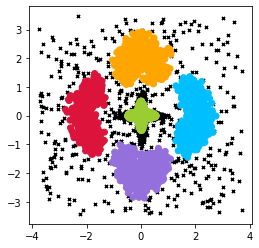

In [112]:
# Mask for real cluster labels (!=-1) and outliers (==-1)
assigned_mask = np.where(clone.labels_ != -1)
outliers_mask = np.where(clone.labels_ == -1)

# Plot
colors = np.array(['deepskyblue', 'Crimson', 'orange', 'mediumpurple', 'yellowgreen'])
mplot.figure(figsize=(4,4))
mplot.scatter(data[outliers_mask,0], data[outliers_mask,1], c='black', marker='x', s=10)
mplot.scatter(data[assigned_mask,0], data[assigned_mask,1], c=colors[clone.labels_[assigned_mask]])
mplot.show()

Range of acceptable value for pdc is large
----

Clustering with pdc=4...
Clustering with pdc=5...
Clustering with pdc=6...
Clustering with pdc=7...
Clustering with pdc=8...
Clustering with pdc=9...
Clustering with pdc=10...
Clustering with pdc=11...
Clustering with pdc=12...
Clustering with pdc=13...
Clustering with pdc=14...
Clustering with pdc=15...


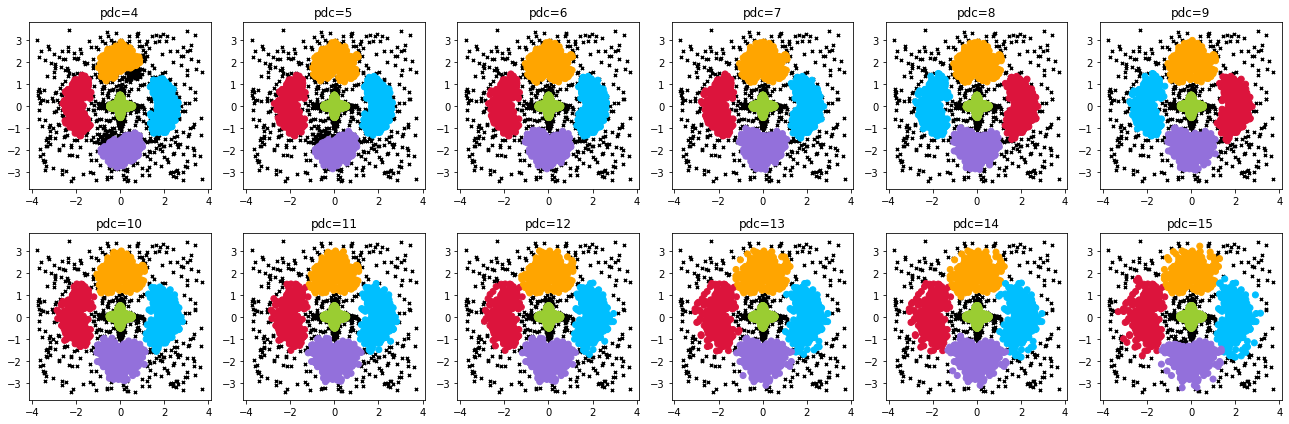

In [113]:
cnt = 1
pdc_range = [4,5,6,7,8,9,10,11,12,13,14,15]
colors = np.array(['deepskyblue', 'Crimson', 'orange', 'mediumpurple', 'yellowgreen'])
fig = mplot.figure(figsize=(18,6))
for pdc in pdc_range:
    print("Clustering with pdc=%i..."%pdc)
    # Cluster
    clone = CLoNe(pdc=pdc)
    clone.fit(data)
    
    # Mask for real cluster labels (!=-1) and outliers (==-1)
    assigned_mask = np.where(clone.labels_ != -1)
    outliers_mask = np.where(clone.labels_ == -1)
    
    # Plot
    ax = fig.add_subplot(2,6,cnt)
    ax.scatter(data[outliers_mask,0], data[outliers_mask,1], c='black', marker='x', s=10)
    ax.scatter(data[assigned_mask,0], data[assigned_mask,1], c=colors[clone.labels_[assigned_mask]])
    ax.set_title("pdc=%i"%pdc)
    cnt += 1
mplot.tight_layout()
mplot.show()

Different values for the unique parameter may yield different hierarchies
----

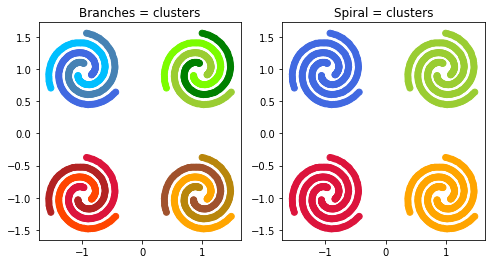

In [114]:
# Dataset
dataset = "spiral_quartet.txt"
with open("examples/%s"%dataset, 'r') as f:
    headers = next(f).split()
    data = np.array([[float(x) for x in line.split()] for line in f])
data = StandardScaler().fit_transform(data)

# Cluster #1
pdc = 2
clone = CLoNe(pdc=pdc)
clone.fit(data)
labels_1 = clone.labels_.copy()

# Cluster #2
pdc = 6
clone = CLoNe(pdc=pdc)
clone.fit(data)
labels_2 = clone.labels_.copy()

# Plot
h_fig = mplot.figure(figsize=(8,4))

ax = h_fig.add_subplot(121)
colors = np.array(['crimson', 'darkgoldenrod', 'green', 'SteelBlue', 
                   'sienna', 'lawngreen', 'firebrick', 'deepskyblue',
                   'royalblue', 'orangered', 'orange', 'yellowgreen'])
assigned_mask = np.where(labels_1 != -1)
outliers_mask = np.where(labels_1 == -1)
ax.scatter(data[outliers_mask,0], data[outliers_mask,1], c='black', marker='x', s=10)
ax.scatter(data[assigned_mask,0], data[assigned_mask,1], c=colors[labels_1[assigned_mask]])
ax.set_title("Branches = clusters")

ax = h_fig.add_subplot(122)
colors = np.array(['Crimson', 'orange',  'yellowgreen', 'royalblue'])
assigned_mask = np.where(labels_2 != -1)
outliers_mask = np.where(labels_2 == -1)
ax.scatter(data[outliers_mask,0], data[outliers_mask,1], c='black', marker='x', s=10)
ax.scatter(data[assigned_mask,0], data[assigned_mask,1], c=colors[labels_2[assigned_mask]])
ax.set_title("Spiral = clusters")
mplot.show()

Visualize core cardinality and distributions
----

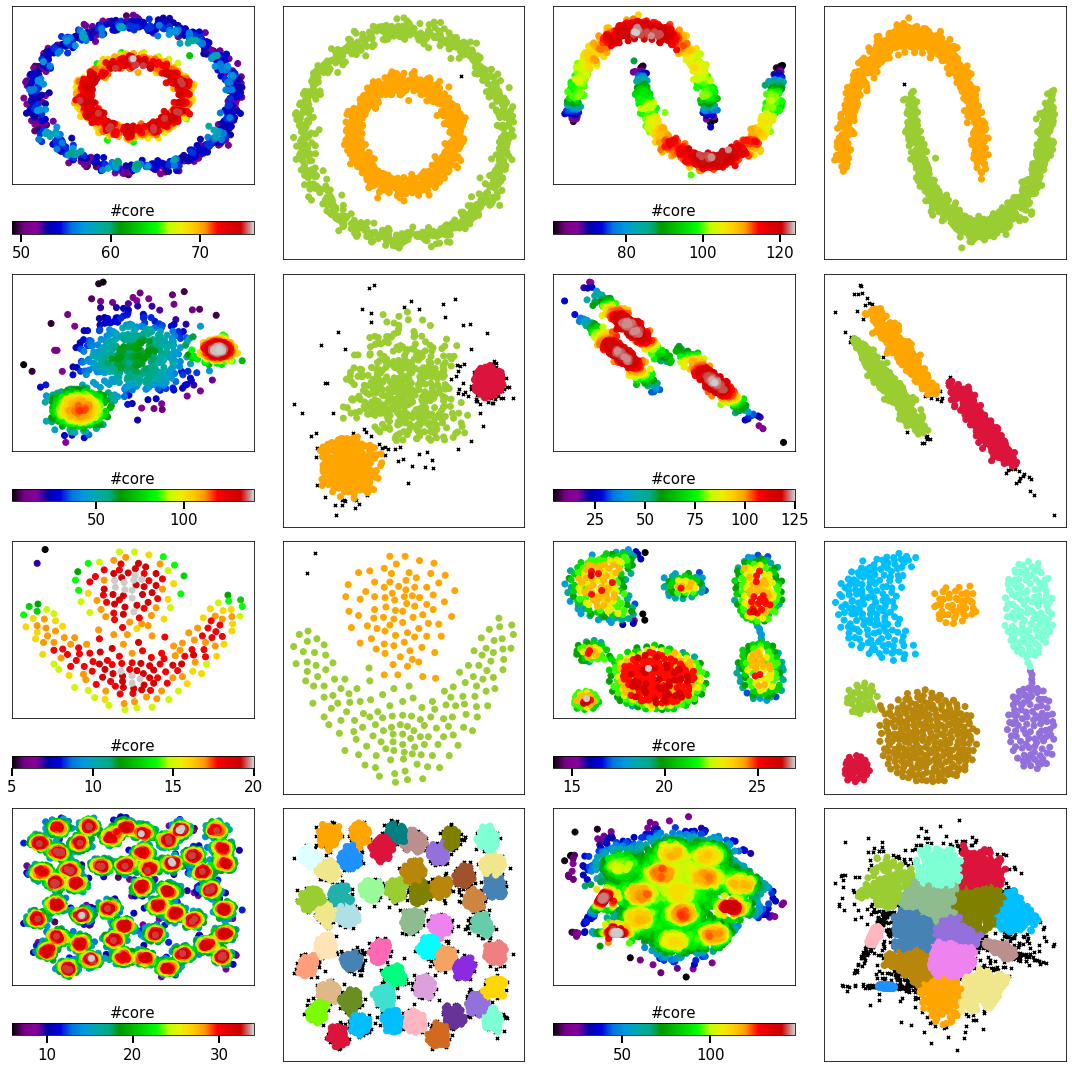

In [115]:
# Dataset + parameter
data_dict = {"noisy_circles.txt": 6, 
             "noisy_moons.txt": 10, 
             "varied.txt": 10, 
             "aniso.txt": 10,
             "flame.txt": 10,
             "aggregation.txt": 4, 
             "a3.txt": 0.5,
             "s4.txt": 3,
             }

# color list for better visualization
color_list = np.array(['yellowgreen', 'orange',  'crimson', 'mediumpurple', 'deepskyblue', 'Aquamarine', 'DarkGoldenRod',
              'Khaki', 'SteelBlue', 'Olive', 'Violet', 'DarkSeaGreen', 'RosyBrown', 'LightPink', 'DodgerBlue',
              'lightcoral', 'chocolate', 'burlywood', 'cyan', 'olivedrab', 'palegreen', 'turquoise', 'gold', 'teal',
              'hotpink', 'moccasin', 'lawngreen', 'sandybrown', 'blueviolet', 'powderblue', 'plum', 'springgreen',
              'mediumaquamarine', 'rebeccapurple', 'peru', 'lightsalmon', 'khaki', 'sienna', 'lightseagreen', 'lightcyan'])
colors = np.array(list(islice(cycle(color_list),200)))

row = 4
col = 4
cnt = 1
fig = mplot.figure(figsize=(15,15))
for dataset in data_dict.keys():
    pdc = data_dict[dataset]
    with open("examples/%s"%dataset, 'r') as f:
        headers = next(f).split()
        data = np.array([[float(x) for x in line.split()] for line in f])
    data = StandardScaler().fit_transform(data)

    # Cluster
    clone = CLoNe(pdc=pdc)
    clone.fit(data)
    
    # Sort values for better visualization
    arcore = np.argsort(clone.core_card)
    s_cores = clone.core_card[arcore]
    s_data = data[arcore]
    
    mplot.subplot(row, col, cnt); cnt += 1
    mplot.scatter(s_data[:, 0], s_data[:, 1], marker='o', c=s_cores, cmap=cm.nipy_spectral)
    mplot.xlabel("#core", labelpad=20, fontsize=15)
    cbar = mplot.colorbar(orientation='horizontal')
    cbar.ax.tick_params(axis='x', which='major', length=8, width=2, labelsize=15)
    cbar.ax.tick_params(axis='y', which='major', length=8, width=2, labelsize=15)
    mplot.xticks([])
    mplot.yticks([])
    mplot.tight_layout()
    
    mplot.subplot(row, col, cnt); cnt += 1
    assigned_mask = np.where(clone.labels_ != -1)
    outliers_mask = np.where(clone.labels_ == -1)
    mplot.scatter(data[outliers_mask,0], data[outliers_mask,1], c='black', marker='x', s=10)
    mplot.scatter(data[assigned_mask,0], data[assigned_mask,1], c=colors[clone.labels_[assigned_mask]])
    mplot.xticks([])
    mplot.yticks([])
    mplot.tight_layout()



2-How to run on structural biology data
----

Example with APP's oligomerisation simulations. Code below is included in the file "md_clone.py", which covers more functionalities.

For full example with structures and VMD scripts, see Readme and the file "md_clone.py"


In [116]:
from sklearn.decomposition import PCA

# Load features
# > File format: 
# header_feat1 header_feat2 ... header_featN
# frame1_val1  frame1_val2  ... frame1_valN
# frame2_val1  frame2_val2  ... frame2_valN
# ...
# frameM_val1  frameM_val2  ... frameM_valN

with open("structural_ensembles/APP_bound_dist_motifs.txt", 'r') as f:
    headers = next(f).split()
    data = np.array([[float(x) for x in line.split()] for line in f])

original_data = data.copy()
pca_obj = PCA(n_components=2)
data = pca_obj.fit_transform(data)
eigenvalues = pca_obj.explained_variance_ratio_
ratio = np.sum(eigenvalues[:2])

# Cluster
clone = CLoNe(pdc=5)
clone.fit(data)

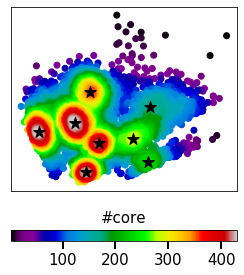

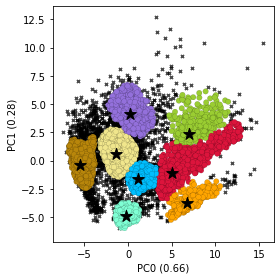

In [123]:
from plot import plot_clusters
pca_headers = ["PC%i (%.2f)"%(eig, idx) for idx, eig in zip(eigenvalues, range(2))]
plot_clusters(clone, data, ".", pca_headers)

In [118]:
# Print stats on cluster sizes/density/cores
header = "  |  #center  |    Dens    #Core  |  # el  | -outl  |"
subh  =  "  |-----------|-------------------|--------|--------|"
top = "   " + "-" * (len(header) - 4)
print(top + "\n" + header + "\n" + subh + "\n" + top)
for cl in range(len(centers)):
    elem = len(labels_all[labels_all == cl])
    outliers = len(labels[labels == cl])
    line =  "  |%2i - %5i | %7.2f  %7i  "%\
            (cl+1, centers[cl], rho[centers[cl]], core[centers[cl]])
    line = line + "| %6i | %6i |"%(elem, outliers)
    print(line)
print(top)
print()


   -------------------------------------------------
  |  #center  |    Dens    #Core  |  # el  | -outl  |
  |-----------|-------------------|--------|--------|
   -------------------------------------------------
  | 1 -  3426 |  126.63      162  |    363 |    352 |
  | 2 -  7038 |  190.24      232  |    430 |    404 |
  | 3 -  8065 |  236.01      274  |    997 |    967 |
  | 4 -   634 |  292.95      347  |   1136 |    974 |
  | 5 -  3280 |  330.83      412  |   1019 |    875 |
  | 6 -  8641 |  346.34      418  |    978 |    880 |
  | 7 -  5635 |  363.07      428  |   2168 |   1745 |
  | 8 -  5210 |  381.70      428  |   2574 |   2219 |
   -------------------------------------------------



In [119]:
# Print stats on clusters based on original features
for r in [range(0, 3), range(3, 5)]:  # divide features according to both motifs
    header = "  |       |"
    subh  =  "  | Frame |"
    for h in [headers[i] for i in r]:
        hs = h[:15].center(15)
        header = header + "      " + hs + "      |"
        subh  =    subh + "   center   median    IQR  |"
    top = "   " + "-" * (len(header) - 4)
    print(top + "\n" + header + "\n" + subh + "\n" + top)
    for cl in range(len(centers)):
        line =  "  | %5i "%(centers[cl])
        iqr_list = []
        for dim in r:
            centr_val = original_data[centers[cl],dim]
            quartile1, median, quartile3 = np.percentile(original_data[labels == cl, dim], [25, 50, 75])
            iqr = quartile3 - quartile1
            line = line + "| %8.2f %8.2f %7.2f "%(centr_val, median, iqr)
        print(line+"|")
    print(top)
    

   -------------------------------------------------------------------------------------------
  |       |           dG700           |           dG704           |           dG708           |
  | Frame |   center   median    IQR  |   center   median    IQR  |   center   median    IQR  |
   -------------------------------------------------------------------------------------------
  |  3426 |    13.60    14.43    2.58 |    12.21    12.69    1.25 |    11.20    11.47    0.60 |
  |  7038 |    11.77    11.96    1.49 |    10.46    10.53    0.91 |     9.87     9.91    0.43 |
  |  8065 |    11.97    12.78    2.52 |    10.51    10.86    1.97 |     8.65     9.37    1.24 |
  |   634 |     9.94     9.71    1.16 |     8.69     9.20    0.61 |     9.55     9.36    0.81 |
  |  3280 |     9.36     8.85    0.85 |     7.90     8.35    0.48 |     7.85     8.10    0.38 |
  |  8641 |     7.39     7.22    0.87 |     6.70     6.69    0.43 |     6.29     6.52    0.43 |
  |  5635 |     5.41     5.29    0.73 |   

In [120]:
traj = "structural_ensembles/APP_bound.xtc"
topo = "structural_ensembles/APP.psf"
struct_ens = mdtraj.load(traj, top=topo)

In [121]:
# Visualize
view = nv.show_mdtraj(struct_ens)

# color BB atoms of both motifs
view.add_representation('ball+stick', selection='.BB and (15 or 19)', aspectRatio=10, color="gold")
view.add_representation('ball+stick', selection='.BB and (20 or 24 or 28)', aspectRatio=10, color="teal")
view

# In the window below, you can enter the frame # of interest next to the slider.
# (e.g. a cluster center from table above)
# Try 7038 or 5635

NGLWidget(max_frame=9664)